In [12]:
import pandas as pd
import numpy as np
from numpy import trapz

num_interp_pts = 11
integration_x = np.linspace(0, 1, num_interp_pts)

# ----------------------
# 1. Load predictions
# ----------------------
preds_xgb = pd.read_csv("XGBoost_preds_vs_targets.csv")
preds_xgb_no_time = pd.read_csv("XGBoost_NoTime_preds_vs_targets.csv")
preds_gru = pd.read_csv("FC-NN_GRU_preds_vs_targets.csv")
preds_lstm = pd.read_csv("FC-NN_LSTM_preds_vs_targets.csv")

# Add curve_id based on num_interp_pts
for df in [preds_xgb, preds_xgb_no_time, preds_gru, preds_lstm]:
    if "index" in df.columns:
        df["curve_id"] = df["index"] // num_interp_pts
    else:
        df["curve_id"] = df.index // num_interp_pts

# ----------------------
# 2. Compute AUCs
# ----------------------
def compute_auc(df):
    return df.groupby(["outer_fold", "curve_id"]).apply(
        lambda g: trapz(g["y_true"].values, integration_x)
    ).reset_index(name="AUC")

auc_xgb = compute_auc(preds_xgb)
auc_xgb_no_time = compute_auc(preds_xgb_no_time)
auc_gru = compute_auc(preds_gru)
auc_lstm = compute_auc(preds_lstm)

# ----------------------
# 3. Pick top/bottom curves from XGB (can be changed)
# ----------------------
sorted_xgb = auc_xgb.sort_values("AUC")
top3_bottom3_xgb = pd.concat([sorted_xgb.head(3), sorted_xgb.tail(3)])

# ----------------------
# 4. Build comparison dictionary
# ----------------------
comparison_data = {}

def get_curve_info(df, auc_df, outer_fold, curve_id):
    subset = df[(df["outer_fold"] == outer_fold) & (df["curve_id"] == curve_id)]
    y_true = subset["y_true"].values
    y_pred = subset["y_pred"].values
    auc_val = auc_df[(auc_df["outer_fold"] == outer_fold) & (auc_df["curve_id"] == curve_id)]["AUC"].iloc[0]
    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "AUC": auc_val
    }

# Populate dictionary with XGB curves as keys
for _, row in top3_bottom3_xgb.iterrows():
    key = tuple(
        preds_xgb[(preds_xgb["outer_fold"]==row["outer_fold"]) &
                  (preds_xgb["curve_id"]==row["curve_id"])]["y_true"].values
    )
    comparison_data[key] = {
        "xgb": get_curve_info(preds_xgb, auc_xgb, row["outer_fold"], row["curve_id"]),
        "xgb_no_time": None,
        "gru": None,
        "lstm": None
    }

# Match curves from other models by y_true
for key in comparison_data.keys():
    for model_name, df, auc_df in [("xgb_no_time", preds_xgb_no_time, auc_xgb_no_time),
                                   ("gru", preds_gru, auc_gru),
                                   ("lstm", preds_lstm, auc_lstm)]:
        matched_rows = df.groupby(["outer_fold", "curve_id"]).filter(
            lambda g: np.allclose(g["y_true"].values, np.array(key), atol=1e-6)
        ).drop_duplicates(subset=["outer_fold", "curve_id"])
        
        if not matched_rows.empty:
            row = matched_rows.iloc[0]
            comparison_data[key][model_name] = get_curve_info(df, auc_df, row["outer_fold"], row["curve_id"])

print("Comparison dictionary ready")


/tmp/ipykernel_2104864/634879758.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(["outer_fold", "curve_id"]).apply(
/tmp/ipykernel_2104864/634879758.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(["outer_fold", "curve_id"]).apply(
/tmp/ipykernel_2104864/634879758.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior i

✅ Comparison dictionary ready


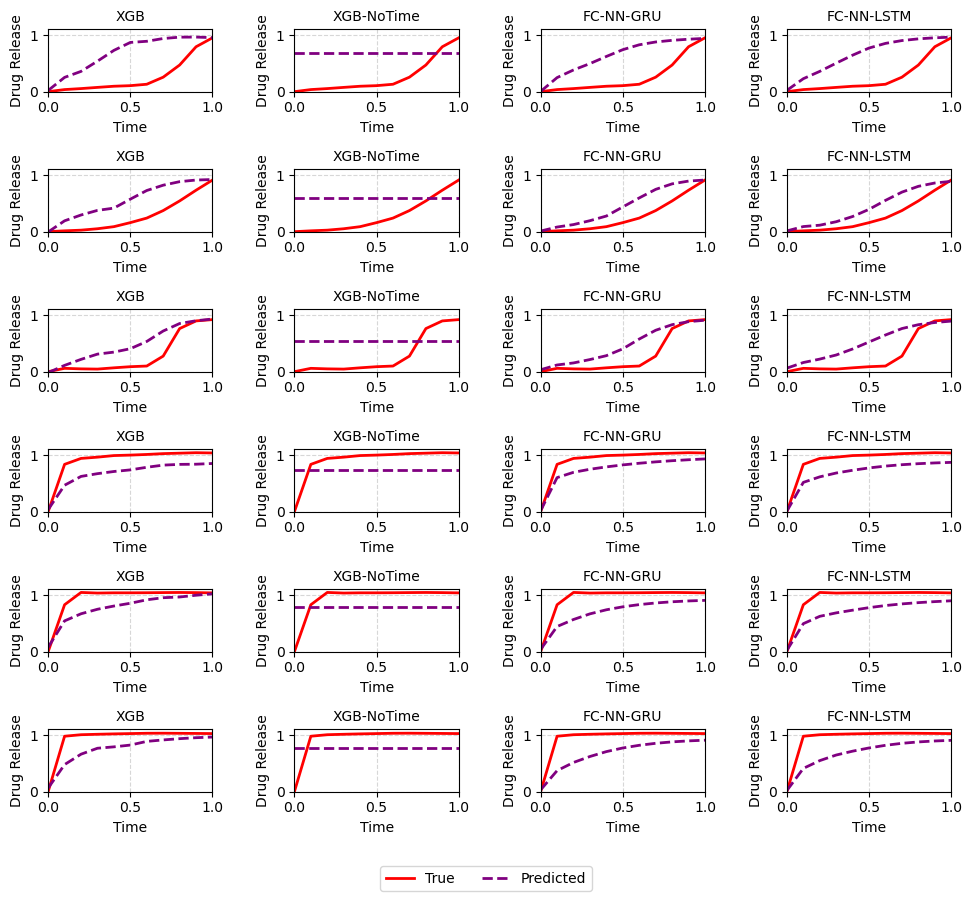

In [31]:
import matplotlib.pyplot as plt

x = integration_x
num_curves = len(comparison_data)
models = ["xgb", "xgb_no_time", "gru", "lstm"]
model_titles = ["XGB", "XGB-NoTime", "FC-NN-GRU", "FC-NN-LSTM"]

fig, axes = plt.subplots(num_curves, 4, figsize=(10, 1.5 * num_curves), squeeze=False)

for i, (y_true_key, curve_data) in enumerate(comparison_data.items()):
    for j, model_name in enumerate(models):
        ax = axes[i, j]
        data = curve_data[model_name]
        if data is not None:
            y_true = data["y_true"]
            y_pred = data["y_pred"]
            auc_val = data["AUC"]
            ax.plot(x, y_true, '-', color='red', lw=2, label='True')
            ax.plot(x, y_pred, '--', color='purple', lw=2, label='Predicted')
            ax.set_title(f"{model_titles[j]}", fontsize=10)
        else:
            ax.text(0.5, 0.5, "No match found", ha='center', va='center')
            ax.set_title(model_titles[j], fontsize=10)
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1.1)
        ax.set_xlabel("Time")
        ax.set_ylabel("Drug Release")
        ax.grid(True, linestyle='--', alpha=0.5)

# Create a single legend below all subplots
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for legend
plt.show()


In [35]:
# Function to calculate per-curve RMSE from a dataframe
def calculate_curve_rmse(df, model_name, num_interp_pts=11):
    """
    df: dataframe containing columns 'outer_fold', 'curve_id', 'y_true', 'y_pred'
    model_name: just for labeling
    """
    rmse_df = (
        df.groupby(["outer_fold", "curve_id"])
        .apply(lambda g: np.sqrt(((g["y_true"] - g["y_pred"])**2).mean()))
        .reset_index(name="RMSE")
    )
    rmse_df["model"] = model_name
    return rmse_df

# Example for XGB
rmse_xgb = calculate_curve_rmse(preds_xgb, "xgb")
rmse_xgb_no_time = calculate_curve_rmse(preds_xgb_no_time, "xgb_no_time")  # make sure you have this df
rmse_gru = calculate_curve_rmse(preds_gru, "gru")  # FC-NN-GRU dataframe
rmse_lstm = calculate_curve_rmse(preds_lstm, "lstm")  # FC-NN-LSTM dataframe

# Combine all into one dataframe for easy comparison
all_curve_rmses = pd.concat([rmse_xgb, rmse_xgb_no_time, rmse_gru, rmse_lstm], ignore_index=True)



      outer_fold  curve_id      RMSE model
0              1         0  0.246692   xgb
1              1         1  0.088115   xgb
2              1         2  0.187001   xgb
3              1         3  0.167210   xgb
4              1         4  0.193075   xgb
...          ...       ...       ...   ...
1279          10        27  0.226119  lstm
1280          10        28  0.150768  lstm
1281          10        29  0.041500  lstm
1282          10        30  0.158965  lstm
1283          10        31  0.115647  lstm

[1284 rows x 4 columns]


/tmp/ipykernel_2104864/3281980098.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.sqrt(((g["y_true"] - g["y_pred"])**2).mean()))
/tmp/ipykernel_2104864/3281980098.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.sqrt(((g["y_true"] - g["y_pred"])**2).mean()))
/tmp/ipykernel_2104864/3281980098.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the group

In [36]:
# -------------------------------
# 1. Merge RMSE and AUC per curve
# -------------------------------
def merge_auc_rmse(rmse_df, auc_df):
    """Merge RMSE and AUC dataframes on outer_fold and curve_id"""
    return pd.merge(rmse_df, auc_df, on=["outer_fold", "curve_id"])

merged_xgb = merge_auc_rmse(rmse_xgb, auc_xgb)
merged_xgb_no_time = merge_auc_rmse(rmse_xgb_no_time, auc_xgb_no_time)
merged_gru = merge_auc_rmse(rmse_gru, auc_gru)
merged_lstm = merge_auc_rmse(rmse_lstm, auc_lstm)

# -----------------------------------
# 2. Split into burst and non-burst
# -----------------------------------
def split_burst(df, threshold=0.5):
    nonburst = df[df["AUC"] < threshold]["RMSE"]
    burst = df[df["AUC"] >= threshold]["RMSE"]
    return nonburst, burst

nb_xgb, b_xgb = split_burst(merged_xgb)
nb_xgb_nt, b_xgb_nt = split_burst(merged_xgb_no_time)
nb_gru, b_gru = split_burst(merged_gru)
nb_lstm, b_lstm = split_burst(merged_lstm)

# -----------------------------------
# 3. Calculate averages and std devs
# -----------------------------------
def summarize_rmse(nonburst, burst, sample_size=None, seed=42):
    summary = {}
    summary['nonburst_mean'] = nonburst.mean()
    summary['nonburst_std'] = nonburst.std()
    summary['burst_mean'] = burst.mean()
    summary['burst_std'] = burst.std()
    
    if sample_size is not None and len(burst) >= sample_size:
        summary['burst_sample_mean'] = burst.sample(n=sample_size, random_state=seed).mean()
    
    summary['overall_mean'] = pd.concat([nonburst, burst]).mean()
    
    if sample_size is not None and len(burst) >= sample_size:
        summary['overall_equal_mean'] = pd.concat([nonburst, burst.sample(n=sample_size, random_state=seed)]).mean()
    
    return summary

# Example usage for GRU
summary_gru = summarize_rmse(nb_gru, b_gru, sample_size=84)
summary_lstm = summarize_rmse(nb_lstm, b_lstm, sample_size=84)

# -----------------------------------
# 4. Print results
# -----------------------------------
def print_summary(model_name, summary):
    print(f"\n=== {model_name} ===")
    print(f"Non-burst RMSE:  mean = {summary['nonburst_mean']:.4f}, std = {summary['nonburst_std']:.4f}")
    print(f"Burst RMSE:      mean = {summary['burst_mean']:.4f}, std = {summary['burst_std']:.4f}")
    if 'burst_sample_mean' in summary:
        print(f"Burst Sampled Mean (84): {summary['burst_sample_mean']:.4f}")
    print(f"Overall Mean: {summary['overall_mean']:.4f}")
    if 'overall_equal_mean' in summary:
        print(f"Overall Mean w Equal Burst+Non-Burst (84): {summary['overall_equal_mean']:.4f}")

# Print GRU and LSTM summaries
print_summary("GRU", summary_gru)
print_summary("LSTM", summary_lstm)

# You can also do the same for XGB and XGB-NoTime if desired
summary_xgb = summarize_rmse(nb_xgb, b_xgb)
summary_xgb_nt = summarize_rmse(nb_xgb_nt, b_xgb_nt)
print_summary("XGB", summary_xgb)
print_summary("XGB-NoTime", summary_xgb_nt)



=== GRU ===
Non-burst RMSE:  mean = 0.1356, std = 0.0942
Burst RMSE:      mean = 0.1298, std = 0.0726
Burst Sampled Mean (84): 0.1289
Overall Mean: 0.1313
Overall Mean w Equal Burst+Non-Burst (84): 0.1322

=== LSTM ===
Non-burst RMSE:  mean = 0.1311, std = 0.0851
Burst RMSE:      mean = 0.1295, std = 0.0685
Burst Sampled Mean (84): 0.1288
Overall Mean: 0.1299
Overall Mean w Equal Burst+Non-Burst (84): 0.1300

=== XGB ===
Non-burst RMSE:  mean = 0.1394, std = 0.0942
Burst RMSE:      mean = 0.1205, std = 0.0645
Overall Mean: 0.1255

=== XGB-NoTime ===
Non-burst RMSE:  mean = 0.3195, std = 0.0653
Burst RMSE:      mean = 0.3007, std = 0.0547
Overall Mean: 0.3056


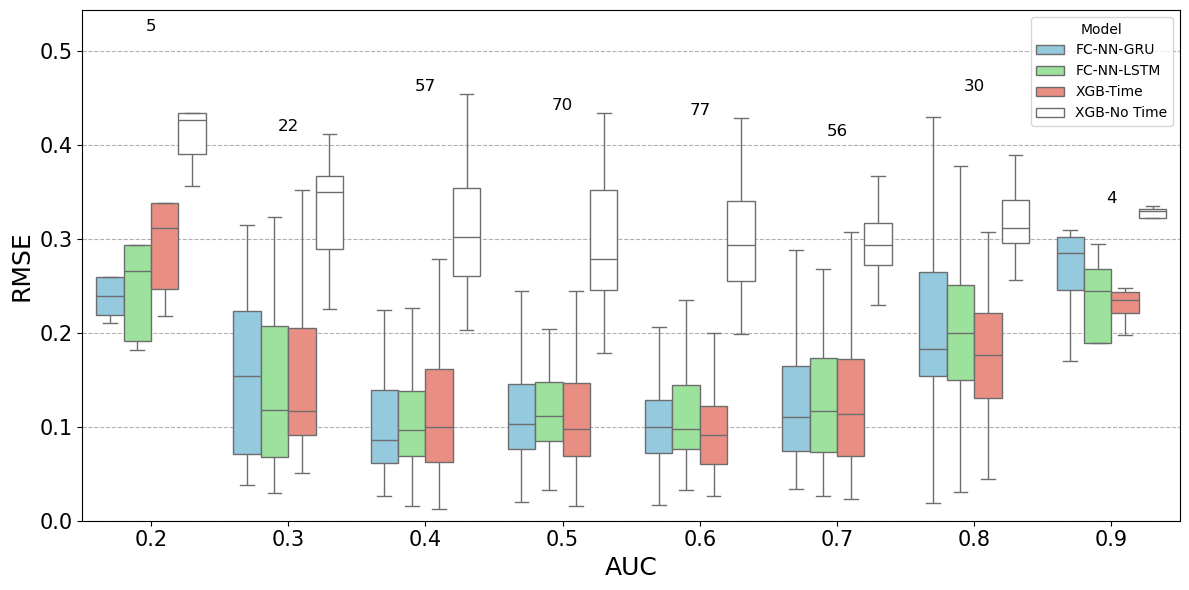

In [59]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_all, x="AUC_bin", y="RMSE", hue="Model",
    palette={
        "FC-NN-GRU": "skyblue",
        "FC-NN-LSTM": "lightgreen",
        "XGB-Time": "salmon",
        "XGB-No Time": "white"
    },
    showfliers=False
)

# Annotate counts once per bin
for i, auc_val in enumerate(auc_bins):
    subset = df_all[df_all["AUC_bin"] == auc_val]
    count = int(len(subset)/4)  # same value for all models in the bin
    y_pos = subset["RMSE"].max()
    ax.text(i, y_pos, str(count), ha='center', va='bottom', fontsize=12)

# Dynamically adjust y-axis limit to fit annotations
y_max = df_all["RMSE"].max() * 1.05
ax.set_ylim(0, y_max)
ax.tick_params(axis='both', labelsize=15)
plt.xlabel("AUC", fontsize=18)
plt.ylabel("RMSE", fontsize=18)
#plt.title("RMSE Distribution per AUC Bin (Counts Shown Once per Bin)", fontsize=14)
plt.grid(axis="y", linestyle="--")
plt.legend(title="Model")#, loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()
